<a href="https://colab.research.google.com/github/shaySirek/avocado-price-predictor-notebook/blob/master/Avocado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset

In [ ]:
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv('avocado.csv')

df['Date'] = pd.to_datetime(df['Date'])
df['month'] = df['Date'].dt.month

seasons_conditions = [(df['month'].between(3,5,inclusive=True)),
                      (df['month'].between(6,8,inclusive=True)),
                      (df['month'].between(9,11,inclusive=True)),
                      (df['month'].between(12,2,inclusive=True))]

df['season'] = np.select(seasons_conditions, range(4))

df = df.drop(['Unnamed: 0', 'Total Volume', 'Total Bags', 'Date', 'year', 'month'], axis=1)
df

,AveragePrice,4046,4225,4770,Small Bags,Large Bags,XLarge Bags,type,region,season
0,1.33,1036.74,54454.85,48.16,8603.62,93.25,0.0,conventional,Albany,0
1,1.35,674.28,44638.81,58.33,9408.07,97.49,0.0,conventional,Albany,0
2,0.93,794.70,109149.67,130.50,8042.21,103.14,0.0,conventional,Albany,0
3,1.08,1132.00,71976.41,72.58,5677.40,133.76,0.0,conventional,Albany,0
4,1.28,941.48,43838.39,75.78,5986.26,197.69,0.0,conventional,Albany,2
...,...,...,...,...,...,...,...,...,...,...
18244,1.63,2046.96,1529.20,0.00,13066.82,431.85,0.0,organic,WestTexNewMexico,0
18245,1.71,1191.70,3431.50,0.00,8940.04,324.80,0.0,organic,WestTexNewMexico,0
18246,1.87,1191.92,2452.79,727.94,9351.80,42.31,0.0,organic,WestTexNewMexico,0
18247,1.93,1527.63,2981.04,727.01,10919.54,50.00,0.0,organic,WestTexNewMexico,0


In [ ]:
Y_COLUMN = 'AveragePrice'
X = df.drop([Y_COLUMN], axis=1)
y = df[Y_COLUMN]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.reset_index().drop(["index"], axis=1)
X_test = X_test.reset_index().drop(["index"], axis=1)
y_train = y_train.reset_index().drop(["index"], axis=1)
y_test = y_test.reset_index().drop(["index"], axis=1)

# Model

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

In [ ]:
def score(pipe, X_test, y_test):
  y_pred = pipe.predict(X_test)
  r2 = r2_score(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  rmse = sqrt(mse)
  return r2, rmse

In [ ]:
numeric_cols = ['4046', '4225', '4770', 'Small Bags', 'Large Bags', 'XLarge Bags']
categorial_cols = ['region', 'type']

In [ ]:
preprocessor = ColumnTransformer([
        ('cat', OrdinalEncoder(), categorial_cols),
        ('num', StandardScaler(), numeric_cols)],
        remainder='passthrough')
preprocessor

ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('cat',
                                 OrdinalEncoder(categories='auto',
                                                dtype=<class 'numpy.float64'>),
                                 ['region', 'type']),
                                ('num',
                                 StandardScaler(copy=True, with_mean=True,
                                                with_std=True),
                                 ['4046', '4225', '4770', 'Small Bags',
                                  'Large Bags', 'XLarge Bags'])],
                  verbose=False)

In [ ]:
params = {'random_state': 42,
          'n_estimators': 5000,
          'max_depth': 8,
          'min_samples_split': 3,
          'learning_rate': 0.01,
          'loss': 'ls'}

gb_pipe = Pipeline([("preprocess", preprocessor), ('gb', GradientBoostingRegressor(**params))])
gb_pipe.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(memory=None,
         steps=[('preprocess',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  OrdinalEncoder(categories='auto',
                                                                 dtype=<class 'numpy.float64'>),
                                                  ['region', 'type']),
                                                 ('num',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  ['4046', '4225', '4770',
                                                   'Small Bags', 'Large Bag..

In [ ]:
gb_r2, gb_rmse = score(gb_pipe, X_test, y_test)
print(f"r2: {gb_r2}\nrmse: {gb_rmse}")

r2: 0.856427071388753
rmse: 0.15188064665784784


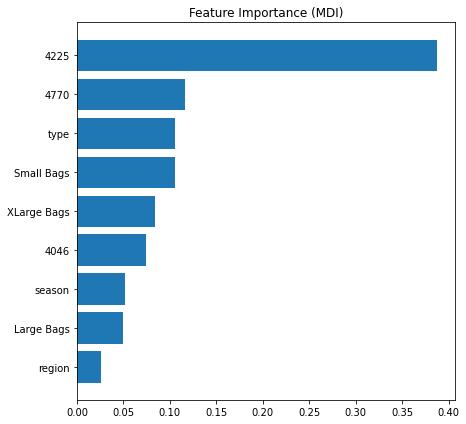

In [ ]:
reg = gb_pipe.steps[1][1]
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X.columns)[sorted_idx])
plt.title('Feature Importance (MDI)')
fig.tight_layout()
plt.show()

In [ ]:
feature_importance[sorted_idx], np.array(X.columns)[sorted_idx]

(array([0.0254613 , 0.04945131, 0.05153732, 0.07459862, 0.08439239,
        0.10565244, 0.10596048, 0.11580412, 0.387142  ]),
 array(['region', 'Large Bags', 'season', '4046', 'XLarge Bags',
        'Small Bags', 'type', '4770', '4225'], dtype=object))

In [ ]:
params = {'random_state': 42,
          'n_estimators': 5000,
          'max_depth': 8,
          'min_samples_split': 3,
          }

rf_pipe = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestRegressor(**params))])
rf_pipe.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rf',
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=8,
                                       max_features='auto', max_leaf_nodes=None,
                                       max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=3,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=5000, n_jobs=None,
                                       oob_score=False, random_state=42,
                                       verbose=0, warm_start=False))],
         verbose=False)

In [ ]:
rf_r2, rf_rmse = score(rf_pipe, X_test, y_test)
print(f"r2: {rf_r2}\nrmse: {rf_rmse}")

r2: 0.7073544483320073
rmse: 0.21683886303773522


# Export

In [ ]:
gb_pipe

Pipeline(memory=None,
         steps=[('preprocess',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  OrdinalEncoder(categories='auto',
                                                                 dtype=<class 'numpy.float64'>),
                                                  ['region', 'type']),
                                                 ('num',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  ['4046', '4225', '4770',
                                                   'Small Bags', 'Large Bag..

In [ ]:
import pickle
s = pickle.dumps(gb_pipe)

In [ ]:
with open('model.pkl', 'wb') as f:
  f.write(s)

In [ ]:
with open('model.pkl', 'rb') as f:
  loaded = f.read()

loaded_pipe = pickle.loads(loaded)
loaded_pipe

Pipeline(memory=None,
         steps=[('preprocess',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  OrdinalEncoder(categories='auto',
                                                                 dtype=<class 'numpy.float64'>),
                                                  ['region', 'type']),
                                                 ('num',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  ['4046', '4225', '4770',
                                                   'Small Bags', 'Large Bag..

In [ ]:
gb_r2, gb_rmse = score(loaded_pipe, X_test, y_test)
print(f"r2: {gb_r2}\nrmse: {gb_rmse}")

r2: 0.856427071388753
rmse: 0.15188064665784784
